# **NYC 311 Request Analysis**

## **Problem Statement**

The New York City Department of Housing Preservation and Development (HPD) needs help answering the following key questions:

* What type of housing complaint should be prioritized first based on frequency, severity, and other factors in the 311 data?

* Are certain boroughs, ZIP codes, or streets experiencing more severe complaints of this top priority type? 

* Does the top complaint type correlate with any particular housing/building characteristics? 

* Can a predictive model be developed to forecast future complaints of the priority type?



## **Goal**

My goal is to deliver data-backed recommendations that provide actionable insights to help HPD manage its growing volume of 311 cases and build a predictive model for forecasting future complaints.

## **NYC 311 Complaint Dataset**

The primary dataset used for this analysis is a preprocessed version of the NYC 311 Complaints dataset obtained from the NYC OpenData portal. This public dataset contains records of complaints filed through the 311 system by NYC residents from 2010 to August 2019. For the purposes of this analysis, the raw 311 data was preprocessed to contain only relevant columns and rows to make the volume more manageable. While similar to 311 datasets used in other analyses, minor differences in the data may lead to small numerical discrepancies. However, these differences do not impact the overall findings and conclusions drawn from the data to address the key questions posed by the NYC Department of Housing Preservation and Development regarding 311 complaint insights.

## **Dataset for Housing**

Here is a revised paragraph about the building characteristics dataset without directly mentioning using CSV files from another source:

The second dataset used in this analysis contains building characteristic information for houses across New York City's five boroughs - Bronx, Brooklyn, Manhattan, Queens, and Staten Island. This dataset was compiled from publicly available sources containing information on various attributes of NYC houses and buildings, such as year built, number of units, building class category, and more. The building characteristics data was consolidated and preprocessed into a single dataset organized with one row per building and columns for each relevant attribute. This consolidated dataset provides important housing insights that can be analyzed in conjunction with the 311 complaints data to identify any correlations between complaint types and building features. As with the 311 data, the building characteristics dataset was preprocessed to contain only necessary information to address the key questions from HPD.

In [1]:
# Importing libraries
import numpy as np 
import pandas as pd
import geopandas as gpd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('/kaggle/input/nyc311opendata/fhrw-4uyv.csv')

In [3]:
data.columns

Index(['created_date', 'unique_key', 'complaint_type', 'incident_zip',
       'incident_address', 'street_name', 'address_type', 'city',
       'resolution_description', 'borough', 'latitude', 'longitude',
       'closed_date', 'location_type', 'status'],
      dtype='object')

In [4]:
data.shape

(5846787, 15)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5846787 entries, 0 to 5846786
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   created_date            object 
 1   unique_key              int64  
 2   complaint_type          object 
 3   incident_zip            float64
 4   incident_address        object 
 5   street_name             object 
 6   address_type            object 
 7   city                    object 
 8   resolution_description  object 
 9   borough                 object 
 10  latitude                float64
 11  longitude               float64
 12  closed_date             object 
 13  location_type           object 
 14  status                  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 669.1+ MB


In [6]:
data.head()

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status
0,2019-08-23T12:35:54.000,43624241,HEAT/HOT WATER,10032.0,560 WEST 160 STREET,WEST 160 STREET,ADDRESS,NEW YORK,The complaint you filed is a duplicate of a co...,MANHATTAN,40.835396,-73.942262,NaN,RESIDENTIAL BUILDING,Open
1,2019-08-23T08:43:58.000,43623659,UNSANITARY CONDITION,11208.0,261 MONTAUK AVENUE,MONTAUK AVENUE,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.672494,-73.877521,NaN,RESIDENTIAL BUILDING,Open
2,2019-08-23T09:08:09.000,43624463,UNSANITARY CONDITION,10002.0,125 MADISON STREET,MADISON STREET,ADDRESS,NEW YORK,The following complaint conditions are still o...,MANHATTAN,40.712353,-73.993947,NaN,RESIDENTIAL BUILDING,Open
3,2019-08-23T16:36:08.000,43625072,DOOR/WINDOW,11211.0,525 UNION AVENUE,UNION AVENUE,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.716233,-73.951986,NaN,RESIDENTIAL BUILDING,Open
4,2019-08-23T11:15:00.000,43623738,UNSANITARY CONDITION,11372.0,35-52F 73 STREET,73 STREET,ADDRESS,Jackson Heights,NaN,QUEENS,40.750533,-73.892998,NaN,RESIDENTIAL BUILDING,Open


In [7]:
data['created_date'] = pd.to_datetime(data['created_date'])
data['closed_date'] = pd.to_datetime(data['closed_date'])

In [8]:
data['Year'] = data['created_date'].dt.year

In [9]:
data.head()

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status,Year
0,2019-08-23 12:35:54,43624241,HEAT/HOT WATER,10032.0,560 WEST 160 STREET,WEST 160 STREET,ADDRESS,NEW YORK,The complaint you filed is a duplicate of a co...,MANHATTAN,40.835396,-73.942262,NaT,RESIDENTIAL BUILDING,Open,2019
1,2019-08-23 08:43:58,43623659,UNSANITARY CONDITION,11208.0,261 MONTAUK AVENUE,MONTAUK AVENUE,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.672494,-73.877521,NaT,RESIDENTIAL BUILDING,Open,2019
2,2019-08-23 09:08:09,43624463,UNSANITARY CONDITION,10002.0,125 MADISON STREET,MADISON STREET,ADDRESS,NEW YORK,The following complaint conditions are still o...,MANHATTAN,40.712353,-73.993947,NaT,RESIDENTIAL BUILDING,Open,2019
3,2019-08-23 16:36:08,43625072,DOOR/WINDOW,11211.0,525 UNION AVENUE,UNION AVENUE,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.716233,-73.951986,NaT,RESIDENTIAL BUILDING,Open,2019
4,2019-08-23 11:15:00,43623738,UNSANITARY CONDITION,11372.0,35-52F 73 STREET,73 STREET,ADDRESS,Jackson Heights,NaN,QUEENS,40.750533,-73.892998,NaT,RESIDENTIAL BUILDING,Open,2019


In [10]:

import requests

# Download the GeoJSON file and save it locally
url = 'https://github.com/codeforgermany/click_that_hood/raw/main/public/data/new-york-city-boroughs.geojson'
response = requests.get(url)
with open('new-york-city-boroughs.geojson', 'wb') as file:
    file.write(response.content)

# Read the locally saved GeoJSON file
gdf = gpd.read_file('new-york-city-boroughs.geojson')


<Axes: >

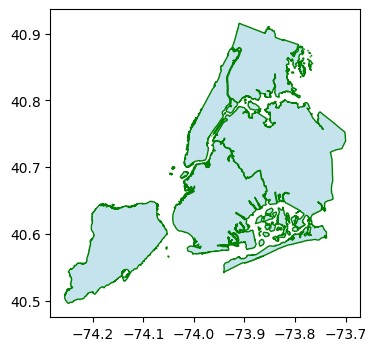

In [11]:
import geopandas as gpd
import requests

# Download the GeoJSON file and save it locally
url = 'https://github.com/codeforgermany/click_that_hood/raw/main/public/data/new-york-city-boroughs.geojson'
response = requests.get(url)
with open('new-york-city-boroughs.geojson', 'wb') as file:
    file.write(response.content)

# Read the locally saved GeoJSON file
borough_map = gpd.read_file('new-york-city-boroughs.geojson')
fig, ax = plt.subplots(figsize = (4, 4))
borough_map['geometry'].boundary.plot(edgecolor='green', linewidth=1, ax=ax)
borough_map.plot(color='lightblue', alpha=0.7, ax=ax)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from scipy import stats

In [13]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict,GridSearchCV, StratifiedKFold,learning_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [15]:
label_size = 17
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['axes.titlesize'] = label_size
plt.rcParams['xtick.labelsize'] = label_size-3
plt.rcParams['ytick.labelsize'] = label_size-3

In [16]:
random_state = 42
scoring_metric = 'accuracy'